In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [6]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [8]:
normalized_scan_100206 = np.load("normalized_scan_100206_full.npy")

In [11]:
quarter_normalized_scan_100206 = normalized_scan_100206[:,0:80]

In [12]:
quarter_bvals_100206 = bvals_all_100206[0:80]

In [13]:
quarter_big_b_indices_100206 = np.where(quarter_bvals_100206 != 0.005)[0]

In [16]:
quarter_normalized_scan_100206_no_b5 = quarter_normalized_scan_100206[:, quarter_big_b_indices_100206]

In [17]:
quarter_normalized_scan_100206_no_b5.shape

(935442, 75)

In [18]:
quarter_bvals_100206_no_5 = quarter_bvals_100206[quarter_big_b_indices_100206]

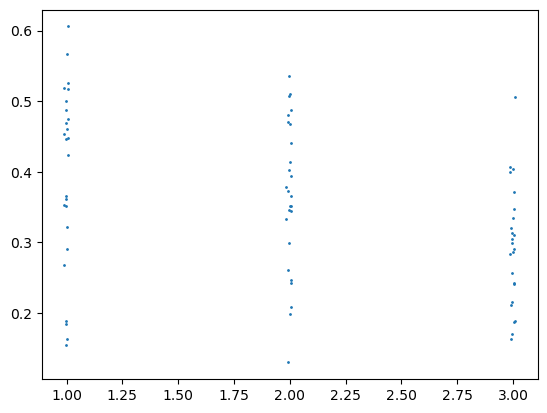

In [20]:
plt.plot(quarter_bvals_100206_no_5, quarter_normalized_scan_100206_no_b5[42,:], "o", markersize = 1)

In [22]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [24]:
n_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvecs')
quarter_n_100206 = n_all_100206[:, 0:80]
quarter_n_100206_no_5 = quarter_n_100206[:,quarter_big_b_indices_100206].T
print(quarter_n_100206_no_5.shape)

quarter_b_values_100206 = torch.FloatTensor(quarter_bvals_100206_no_5)
quarter_gradient_directions_100206 = torch.FloatTensor(quarter_n_100206_no_5)

net = BallStickNet(quarter_gradient_directions_100206, quarter_b_values_100206)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(75, 3)


In [25]:
batch_size = 128
num_batches = len(quarter_normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(quarter_normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [26]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 312.21it/s]


Loss: 599.9292234806344
Average Loss: 0.08209212143960515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.65it/s]


Loss: 449.2457505846396
Average Loss: 0.061473145947542364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.25it/s]


Loss: 442.4584845318459
Average Loss: 0.060544401276935673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.85it/s]


Loss: 442.0025658486411
Average Loss: 0.06048201503128641
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.87it/s]


Loss: 440.7950227847323
Average Loss: 0.060316779253521115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.72it/s]


Loss: 440.49621638748795
Average Loss: 0.0602758916786382
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.64it/s]


Loss: 439.8673422122374
Average Loss: 0.060189838835828874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.37it/s]


Loss: 439.4329550266266
Average Loss: 0.060130398881585466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 305.87it/s]


Loss: 439.4727660664357
Average Loss: 0.06013584647871315
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.44it/s]


Loss: 439.37309154262766
Average Loss: 0.06012220738131194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|█▏                                                        | 155/7308 [00:02<00:48, 147.65it/s]

X_batch: 
torch.Size([128, 75])
tensor([[0.4247, 0.2271, 0.1957,  ..., 0.3635, 0.3170, 0.2257],
        [0.5364, 0.2917, 0.3884,  ..., 0.4161, 0.2782, 0.1898],
        [0.0751, 0.0132, 0.0270,  ..., 0.0958, 0.0284, 0.0282],
        ...,
        [0.1033, 0.1330, 0.1285,  ..., 0.1184, 0.1108, 0.1124],
        [0.4790, 0.2996, 0.1403,  ..., 0.4537, 0.2728, 0.2295],
        [0.3623, 0.2415, 0.1124,  ..., 0.3826, 0.1693, 0.2189]])
X_pred: 
torch.Size([128, 75])
tensor([[0.4635, 0.2706, 0.1729,  ..., 0.4619, 0.2476, 0.2768],
        [0.5022, 0.3288, 0.2271,  ..., 0.4981, 0.2955, 0.3375],
        [0.0887, 0.0342, 0.0256,  ..., 0.0897, 0.0305, 0.0355],
        ...,
        [0.1811, 0.1121, 0.0878,  ..., 0.1804, 0.0990, 0.1164],
        [0.4825, 0.2631, 0.1522,  ..., 0.4830, 0.2482, 0.2672],
        [0.4084, 0.1935, 0.1024,  ..., 0.4098, 0.1827, 0.1961]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.01it/s]


Loss: 439.1056754682213
Average Loss: 0.06008561514343477
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 313.25it/s]


Loss: 438.75367975002155
Average Loss: 0.06003744933634668
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.60it/s]


Loss: 437.93536867247894
Average Loss: 0.05992547464045962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.19it/s]


Loss: 438.19280963903293
Average Loss: 0.059960701921049936
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.83it/s]


Loss: 438.15286503732204
Average Loss: 0.059955236047799954
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.23it/s]


Loss: 437.7581996517256
Average Loss: 0.059901231479436996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.05it/s]


Loss: 437.7689214637503
Average Loss: 0.059902698612992654
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.92it/s]


Loss: 437.69224107638
Average Loss: 0.05989220594914888
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.10it/s]


Loss: 437.17791717732325
Average Loss: 0.05982182774730751
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.93it/s]


Loss: 436.9383729575202
Average Loss: 0.0597890493921073
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.83it/s]


Loss: 436.5771314413287
Average Loss: 0.059739618423827134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.43it/s]


Loss: 436.55769262230024
Average Loss: 0.059736958486904794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.80it/s]


Loss: 436.6174171892926
Average Loss: 0.05974513097828306
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.22it/s]


Loss: 436.3332130634226
Average Loss: 0.059706241524825204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.53it/s]


Loss: 436.3337625467684
Average Loss: 0.05970631671411719
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.66it/s]


Loss: 436.0370274093002
Average Loss: 0.059665712562848965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.47it/s]


Loss: 436.0880952933803
Average Loss: 0.05967270050538866
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.68it/s]


Loss: 435.7796095071826
Average Loss: 0.0596304884383118
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.15it/s]


Loss: 435.7867997584399
Average Loss: 0.05963147232600436
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.20it/s]


Loss: 435.02235912228934
Average Loss: 0.05952686906435267
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.19it/s]


Loss: 435.4674447430298
Average Loss: 0.05958777295334288
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.80it/s]


Loss: 435.1946772567462
Average Loss: 0.059550448447830626
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.49it/s]


Loss: 435.3494858671911
Average Loss: 0.05957163189206228
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.56it/s]


Loss: 434.85779815143906
Average Loss: 0.05950435114278039
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.36it/s]


Loss: 434.9377922685817
Average Loss: 0.059515297245290325
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.43it/s]


Loss: 434.92062978749163
Average Loss: 0.05951294879412858
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.92it/s]


Loss: 434.46856274898164
Average Loss: 0.05945108959345671
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.29it/s]


Loss: 434.44381602690555
Average Loss: 0.059447703342488445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 305.08it/s]


Loss: 434.73862674855627
Average Loss: 0.059488044163732386
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.94it/s]


Loss: 434.59869875432923
Average Loss: 0.05946889692861648
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.05it/s]


Loss: 434.35370589676313
Average Loss: 0.05943537300174646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.10it/s]


Loss: 433.76261684438214
Average Loss: 0.0593544905369981
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 308.18it/s]


Loss: 433.82049674377777
Average Loss: 0.05936241061080703
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.42it/s]


Loss: 433.63978518312797
Average Loss: 0.059337682701577445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 304.03it/s]


Loss: 433.63310612528585
Average Loss: 0.05933676876372275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.51it/s]


Loss: 433.25743992091157
Average Loss: 0.05928536397385216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 310.25it/s]


Loss: 432.90320437122136
Average Loss: 0.059236891676412336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.75it/s]


Loss: 433.0591097776778
Average Loss: 0.059258225202200025
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 315.17it/s]


Loss: 432.76410528761335
Average Loss: 0.05921785786639482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.05it/s]


Loss: 432.197470693849
Average Loss: 0.05914032166035153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.24it/s]


Loss: 432.276533518685
Average Loss: 0.05915114032822729
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.99it/s]


Loss: 432.1109440154396
Average Loss: 0.05912848166604264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.61it/s]


Loss: 431.93039667326957
Average Loss: 0.0591037762278694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 304.99it/s]


Loss: 431.14472224609926
Average Loss: 0.05899626741189098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 308.71it/s]


Loss: 431.04942438937724
Average Loss: 0.05898322720161155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.21it/s]


Loss: 431.06517165573314
Average Loss: 0.05898538199996348
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.52it/s]


Loss: 430.9135428292211
Average Loss: 0.05896463366573907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 304.15it/s]


Loss: 430.74082511267625
Average Loss: 0.05894099960490917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 310.50it/s]


Loss: 429.914561257232
Average Loss: 0.058827936679971535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.71it/s]


Loss: 430.034548610216
Average Loss: 0.05884435531064806
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.78it/s]


Loss: 429.9310634757858
Average Loss: 0.05883019478322192
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.30it/s]


Loss: 429.74698448972777
Average Loss: 0.05880500608781168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.21it/s]


Loss: 429.58112274389714
Average Loss: 0.058782310172947064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.98it/s]


Loss: 429.1687313504517
Average Loss: 0.058725880042481075
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.42it/s]


Loss: 428.9389462803956
Average Loss: 0.058694437093650194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.32it/s]


Loss: 428.67312220903113
Average Loss: 0.05865806269964849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.88it/s]


Loss: 428.11620340682566
Average Loss: 0.05858185596699859
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.19it/s]


Loss: 428.47320554452017
Average Loss: 0.05863070683422553
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.58it/s]


Loss: 428.1085020909086
Average Loss: 0.05858080214708656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.12it/s]


Loss: 427.8124531544745
Average Loss: 0.058540291893058906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.07it/s]


Loss: 428.0294105161447
Average Loss: 0.058569979545175795
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.86it/s]


Loss: 427.59756656037644
Average Loss: 0.05851088759720532
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.17it/s]


Loss: 427.7039731973782
Average Loss: 0.058525447892361554
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 306.16it/s]


Loss: 427.2568608894944
Average Loss: 0.05846426667891275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 312.85it/s]


Loss: 427.22397278412245
Average Loss: 0.05845976639082135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.44it/s]


Loss: 426.70666889101267
Average Loss: 0.05838898041748942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 308.90it/s]


Loss: 426.9605242165271
Average Loss: 0.05842371705206994
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.84it/s]


Loss: 426.9472268028185
Average Loss: 0.05842189748259694
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.58it/s]


Loss: 426.57405757461675
Average Loss: 0.058370834369816195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.09it/s]


Loss: 426.8535587878432
Average Loss: 0.058409080293903015
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.84it/s]


Loss: 426.27808875008486
Average Loss: 0.058330335078008326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.22it/s]


Loss: 426.6728460190352
Average Loss: 0.05838435221935347
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.45it/s]


Loss: 426.1512306132354
Average Loss: 0.058312976274389076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 305.88it/s]


Loss: 426.3142750116531
Average Loss: 0.058335286673734686
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.83it/s]


Loss: 425.7195806070231
Average Loss: 0.05825391086576671
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.10it/s]


Loss: 426.04180152271874
Average Loss: 0.05829800239774476
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.32it/s]


Loss: 425.8900081368629
Average Loss: 0.058277231545821415
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.09it/s]


Loss: 425.68298287596554
Average Loss: 0.05824890296605987
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.09it/s]


Loss: 425.5798028456047
Average Loss: 0.05823478418795905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.28it/s]


Loss: 425.4971650678199
Average Loss: 0.05822347633659276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.75it/s]


Loss: 425.195071374299
Average Loss: 0.0581821389401066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.84it/s]


Loss: 425.4751851516776
Average Loss: 0.05822046868523229
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 314.63it/s]


Loss: 425.1073009497486
Average Loss: 0.058170128756123235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 305.20it/s]


Loss: 424.9943525888957
Average Loss: 0.0581546733153935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 304.60it/s]


Loss: 425.1179737166967
Average Loss: 0.05817158917852993
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 312.79it/s]


Loss: 425.1597350400407
Average Loss: 0.058177303645325765
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.28it/s]


Loss: 424.8962173881009
Average Loss: 0.05814124485332525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 313.90it/s]


Loss: 425.01649188250303
Average Loss: 0.058157702775383555
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.71it/s]


Loss: 424.6881569304969
Average Loss: 0.05811277462103132
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 313.29it/s]


Loss: 424.8373117316514
Average Loss: 0.05813318441867151
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 313.16it/s]


Loss: 424.536046592053
Average Loss: 0.05809196039847469
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 310.44it/s]


Loss: 424.68487708619796
Average Loss: 0.058112325819129444
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.26it/s]


Loss: 424.4992982982658
Average Loss: 0.05808693189631442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 313.82it/s]


Loss: 424.3044976503588
Average Loss: 0.05806027608789803
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 308.89it/s]


Loss: 424.3732900915202
Average Loss: 0.05806968939402301
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.96it/s]


Loss: 424.37036582943983
Average Loss: 0.05806928924869182
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 304.67it/s]


Loss: 423.94046566379257
Average Loss: 0.05801046328185448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 310.16it/s]


Loss: 424.41408274206333
Average Loss: 0.058075271311174514
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 306.44it/s]


Loss: 424.01407700707205
Average Loss: 0.05802053598892611
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.80it/s]


Loss: 423.84208902716637
Average Loss: 0.05799700178258981
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.04it/s]


Loss: 423.87334755365737
Average Loss: 0.05800127908506532
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.39it/s]


Loss: 424.1162806064822
Average Loss: 0.05803452115578574
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 312.04it/s]


Loss: 423.9349512204062
Average Loss: 0.05800970870558377
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 316.10it/s]


Loss: 423.97590705542825
Average Loss: 0.058015312952302715
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.70it/s]


Loss: 423.981763869524
Average Loss: 0.0580161143773295
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 306.00it/s]


Loss: 423.45995279960334
Average Loss: 0.05794471165840221
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 308.94it/s]


Loss: 423.48606357723475
Average Loss: 0.05794828456174531
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.03it/s]


Loss: 423.41898052138276
Average Loss: 0.057939105161656096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.82it/s]


Loss: 423.45518202660605
Average Loss: 0.05794405884326848
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.15it/s]


Loss: 423.39045628067106
Average Loss: 0.05793520200884935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.92it/s]


Loss: 423.78775823884644
Average Loss: 0.05798956735616399
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.37it/s]


Loss: 423.3542398000136
Average Loss: 0.057930246278053314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.40it/s]


Loss: 423.29750839131884
Average Loss: 0.0579224833595127
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 310.65it/s]


Loss: 423.4295807664748
Average Loss: 0.05794055566043717
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.59it/s]


Loss: 423.2882128225174
Average Loss: 0.057921211387865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.78it/s]


Loss: 423.2484150598757
Average Loss: 0.057915765607536356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.43it/s]


Loss: 423.1321613974869
Average Loss: 0.05789985788142952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.25it/s]


Loss: 423.3286748593673
Average Loss: 0.05792674806504752
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.59it/s]


Loss: 423.14040671661496
Average Loss: 0.05790098614075191
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.25it/s]


Loss: 423.0838616504334
Average Loss: 0.05789324872063949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.94it/s]


Loss: 423.19710433809087
Average Loss: 0.05790874443597303
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.17it/s]


Loss: 423.17362191993743
Average Loss: 0.0579055311877309
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.42it/s]


Loss: 423.1779027523007
Average Loss: 0.05790611696117963
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.23it/s]


Loss: 423.01001435052603
Average Loss: 0.05788314372612562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.73it/s]


Loss: 423.11751767410897
Average Loss: 0.05789785408786385
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.08it/s]


Loss: 423.1907074828632
Average Loss: 0.057907869113692285
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.56it/s]


Loss: 423.06297184014693
Average Loss: 0.05789039023537862
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.99it/s]


Loss: 422.8459445522167
Average Loss: 0.05786069301480797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.24it/s]


Loss: 422.75447720615193
Average Loss: 0.05784817695760152
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.65it/s]


Loss: 422.8508017214481
Average Loss: 0.05786135765208649
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.93it/s]


Loss: 422.87129477621056
Average Loss: 0.05786416184677211
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.51it/s]


Loss: 422.9294440050144
Average Loss: 0.05787211877463251
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.95it/s]


Loss: 422.79733703355305
Average Loss: 0.057854041739676114
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.89it/s]


Loss: 422.7354572159238
Average Loss: 0.057845574331680874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.56it/s]


Loss: 422.75870284345
Average Loss: 0.057848755178359336
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.13it/s]


Loss: 422.6122374453116
Average Loss: 0.057828713388794695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.59it/s]


Loss: 422.6146973199211
Average Loss: 0.0578290499890423
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.13it/s]


Loss: 422.85372105659917
Average Loss: 0.0578617571232347
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.47it/s]


Loss: 422.4624251553323
Average Loss: 0.05780821362278767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.87it/s]


Loss: 422.3432340747677
Average Loss: 0.057791903951117635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.92it/s]


Loss: 422.41874879132956
Average Loss: 0.057802237108829986
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.52it/s]


Loss: 422.4736722044181
Average Loss: 0.05780975262786236
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.66it/s]


Loss: 422.60166687564924
Average Loss: 0.05782726695069092
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 304.41it/s]


Loss: 422.41888890229166
Average Loss: 0.057802256281101756
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 304.78it/s]


Loss: 422.4556853675749
Average Loss: 0.057807291374873414
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.89it/s]


Loss: 422.3581464863382
Average Loss: 0.05779394451099319
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 304.22it/s]


Loss: 422.4211035994813
Average Loss: 0.057802559332167665
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.14it/s]


Loss: 422.1721709733829
Average Loss: 0.05776849630177653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.93it/s]


Loss: 422.2443640513811
Average Loss: 0.05777837493861263
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 314.34it/s]


Loss: 422.414993457729
Average Loss: 0.057801723242710594
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 314.84it/s]


Loss: 422.3381202653982
Average Loss: 0.05779120419614096
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.54it/s]


Loss: 422.12802060786635
Average Loss: 0.05776245492718478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.58it/s]


Loss: 422.2292307233438
Average Loss: 0.057776304149335496
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 313.44it/s]


Loss: 422.14916890626773
Average Loss: 0.057765348783014196
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.95it/s]


Loss: 422.19650304317474
Average Loss: 0.0577718258132423
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 304.96it/s]


Loss: 422.1491417104844
Average Loss: 0.05776534506164264
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.95it/s]


Loss: 422.1651074164547
Average Loss: 0.05776752975047273
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.23it/s]


Loss: 422.30712961172685
Average Loss: 0.05778696354840269
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.48it/s]


Loss: 421.94265591097064
Average Loss: 0.057737090299804415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.72it/s]


Loss: 422.08218004531227
Average Loss: 0.057756182272210216
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 305.23it/s]


Loss: 422.26416145893745
Average Loss: 0.05778108394347803
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.05it/s]


Loss: 422.0369090551976
Average Loss: 0.05774998755544576
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.22it/s]


Loss: 422.0349800672848
Average Loss: 0.05774972359979266
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.62it/s]


Loss: 421.85139991156757
Average Loss: 0.05772460316250241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.27it/s]


Loss: 422.1097566434182
Average Loss: 0.05775995575306763
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.08it/s]


Loss: 421.9638046254404
Average Loss: 0.057739984212567104
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.66it/s]


Loss: 421.98978519346565
Average Loss: 0.05774353929850378
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.36it/s]


Loss: 421.9795804133173
Average Loss: 0.05774214291369969
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.28it/s]


Loss: 421.94038045499474
Average Loss: 0.057736778934728346
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:22<00:00, 326.69it/s]


Loss: 421.88067807699554
Average Loss: 0.057728609479610775
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 306.00it/s]


Loss: 422.0083012918476
Average Loss: 0.05774607297370657
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.50it/s]


Loss: 421.93138017016463
Average Loss: 0.057735547368659636
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.86it/s]


Loss: 421.83727494068444
Average Loss: 0.057722670353131424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 314.97it/s]


Loss: 421.82411651709117
Average Loss: 0.05772086980255763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.28it/s]


Loss: 421.71560314577073
Average Loss: 0.05770602122958001
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.71it/s]


Loss: 421.7356842106674
Average Loss: 0.057708769049078734
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:21<00:00, 337.92it/s]


Loss: 421.80758651858196
Average Loss: 0.05771860789799972
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 316.65it/s]


Loss: 421.8790959853213
Average Loss: 0.05772839299197063
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.09it/s]


Loss: 421.7749520568177
Average Loss: 0.05771414231757221
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 314.67it/s]


Loss: 421.6303420451004
Average Loss: 0.05769435441230164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.01it/s]


Loss: 421.8079528189264
Average Loss: 0.05771865802119956
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.82it/s]


Loss: 421.5639457083307
Average Loss: 0.05768526898034082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:22<00:00, 330.33it/s]


Loss: 421.7440170440823
Average Loss: 0.057709909283536164
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 304.69it/s]


Loss: 421.74282237514853
Average Loss: 0.0577097458094073
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.09it/s]


Loss: 421.50543138966896
Average Loss: 0.05767726209491912
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.01it/s]


Loss: 421.63213303219527
Average Loss: 0.05769459948442738
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.09it/s]


Loss: 421.64892666460946
Average Loss: 0.05769689746368493
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.64it/s]


Loss: 421.72103005624376
Average Loss: 0.05770676382816691
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.50it/s]


Loss: 421.39610664662905
Average Loss: 0.05766230249680201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.39it/s]


Loss: 421.4905533317942
Average Loss: 0.057675226235877695
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.75it/s]


Loss: 421.5046810125932
Average Loss: 0.057677159416063654
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.39it/s]


Loss: 421.6484170514159
Average Loss: 0.0576968277300788
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.84it/s]


Loss: 421.5411560910288
Average Loss: 0.05768215053243416
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.26it/s]


Loss: 421.52650457946584
Average Loss: 0.057680145673161716
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.01it/s]


Loss: 421.346075585112
Average Loss: 0.05765545642927093
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.06it/s]


Loss: 421.44639557995833
Average Loss: 0.05766918385056901
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 114.07it/s]


Loss: 421.6484268542845
Average Loss: 0.0576968290714675
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.93it/s]


Loss: 421.30179394455627
Average Loss: 0.05764939709148279
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.44it/s]


Loss: 421.36246838769875
Average Loss: 0.057657699560440444
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.07it/s]


Loss: 421.51107742707245
Average Loss: 0.057678034678034
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.06it/s]


Loss: 421.33781152265146
Average Loss: 0.057654325605179454
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.96it/s]


Loss: 421.43549916823395
Average Loss: 0.057667692825428836
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.46it/s]


Loss: 421.2340324127581
Average Loss: 0.05764012485122579
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.90it/s]


Loss: 421.38646612502635
Average Loss: 0.05766098332307421
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.37it/s]


Loss: 421.21782434009947
Average Loss: 0.05763790699782423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 305.06it/s]


Loss: 421.25526221329346
Average Loss: 0.05764302985950923
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.60it/s]


Loss: 421.3501125681214
Average Loss: 0.05765600883526566
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.48it/s]


Loss: 421.3447317390237
Average Loss: 0.057655272542285675
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.26it/s]


Loss: 421.2540091748815
Average Loss: 0.05764285839831438
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.35it/s]


Loss: 421.386176135391
Average Loss: 0.05766094364195279
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.23it/s]


Loss: 421.1377462709788
Average Loss: 0.05762694940763257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.89it/s]


Loss: 421.2160313448403
Average Loss: 0.05763766165090863
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.36it/s]


Loss: 421.12724789744243
Average Loss: 0.05762551284858271
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.80it/s]


Loss: 421.11118420772254
Average Loss: 0.05762331475201458
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.43it/s]


Loss: 421.0838151711505
Average Loss: 0.05761956967311857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.09it/s]


Loss: 421.06933010858484
Average Loss: 0.05761758759011834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.00it/s]


Loss: 421.0170816606842
Average Loss: 0.0576104381035419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.01it/s]


Loss: 421.20672309189104
Average Loss: 0.057636387943608515
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.11it/s]


Loss: 421.0407910330687
Average Loss: 0.05761368240737119
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 304.08it/s]


Loss: 421.2261605556123
Average Loss: 0.05763904769507557
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.99it/s]


Loss: 421.08667582203634
Average Loss: 0.05761996111412648
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.80it/s]


Loss: 420.984661544906
Average Loss: 0.05760600185343541
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.48it/s]


Loss: 421.17814713926055
Average Loss: 0.05763247771473187
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.17it/s]


Loss: 421.2097652000375
Average Loss: 0.05763680421456452
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.17it/s]


Loss: 421.04521721298806
Average Loss: 0.057614288069648065
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.55it/s]


Loss: 421.16639287397265
Average Loss: 0.057630869304046616
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.90it/s]


Loss: 421.10154740861617
Average Loss: 0.057621996087659576
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.52it/s]


Loss: 421.02681569173
Average Loss: 0.05761177007275999
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.46it/s]


Loss: 420.9801703027915
Average Loss: 0.057605387288285646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.00it/s]


Loss: 420.8763162030373
Average Loss: 0.05759117627299361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.91it/s]


Loss: 420.97707239654846
Average Loss: 0.05760496338212212
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.02it/s]


Loss: 421.0423488211818
Average Loss: 0.05761389556940091
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.20it/s]


Loss: 421.0138564170338
Average Loss: 0.05760999677299313
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.79it/s]


Loss: 420.89554598368704
Average Loss: 0.057593807605868505
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.85it/s]


Loss: 421.0568911356386
Average Loss: 0.057615885486540584
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.80it/s]


Loss: 420.83888965658844
Average Loss: 0.057586054961219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.77it/s]


Loss: 420.9810632595327
Average Loss: 0.05760550947722122
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.13it/s]


Loss: 420.95272175385617
Average Loss: 0.057601631329208564
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.37it/s]


Loss: 420.8579326784238
Average Loss: 0.05758866073870058
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.09it/s]


Loss: 420.9273832582403
Average Loss: 0.05759816410211279
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.50it/s]


Loss: 420.84500006306916
Average Loss: 0.057586891086900543
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.11it/s]


Loss: 420.87728547211736
Average Loss: 0.05759130890423062
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.57it/s]


Loss: 420.8251052694395
Average Loss: 0.05758416875608094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.26it/s]


Loss: 420.8929482046515
Average Loss: 0.057593452135283454
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.57it/s]


Loss: 420.90085762762465
Average Loss: 0.05759453443180414
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.78it/s]


Loss: 421.0070387281012
Average Loss: 0.057609063865366884
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.11it/s]


Loss: 420.7837037181016
Average Loss: 0.057578503519170994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.09it/s]


Loss: 420.95175995933823
Average Loss: 0.057601499720763304
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.72it/s]


Loss: 420.83060144865885
Average Loss: 0.05758492083314982
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.53it/s]


Loss: 420.89690824295394
Average Loss: 0.057593994012445804
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 305.53it/s]


Loss: 420.87244906811975
Average Loss: 0.05759064710839077
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.01it/s]


Loss: 420.822440528078
Average Loss: 0.05758380412261604
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.54it/s]


Loss: 420.8529628235847
Average Loss: 0.057587980681935505
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.68it/s]


Loss: 420.720422974322
Average Loss: 0.05756984441356349
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.96it/s]


Loss: 420.8091724088881
Average Loss: 0.05758198856169788
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.56it/s]


Loss: 420.8230117375497
Average Loss: 0.05758388228483165
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.35it/s]


Loss: 420.6799190142192
Average Loss: 0.05756430199975632
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.05it/s]


Loss: 420.71739957039244
Average Loss: 0.057569430702024145
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.24it/s]


Loss: 420.7557664141059
Average Loss: 0.057574680680638465
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.74it/s]


Loss: 420.761296591023
Average Loss: 0.05757543740982799
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.26it/s]


Loss: 420.7473521323409
Average Loss: 0.057573529301086605
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.28it/s]


Loss: 420.74039952014573
Average Loss: 0.05757257793105442
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.59it/s]


Loss: 420.7352802413516
Average Loss: 0.057571877427661684
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.96it/s]


Loss: 420.74387031351216
Average Loss: 0.057573052861728535
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.94it/s]


Loss: 420.649460823508
Average Loss: 0.05756013421230268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.54it/s]


Loss: 420.681202683365
Average Loss: 0.05756447765234879
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.47it/s]


Loss: 420.59618730680086
Average Loss: 0.057552844459058686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.92it/s]


Loss: 420.62768603651784
Average Loss: 0.05755715463006539
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.16it/s]


Loss: 420.65110458014533
Average Loss: 0.05756035913795092
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 310.34it/s]


Loss: 420.6623022663407
Average Loss: 0.057561891388388166
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.52it/s]


Loss: 420.6423455537297
Average Loss: 0.057559160584801546
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.00it/s]


Loss: 420.6245201441925
Average Loss: 0.05755672142093494
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.29it/s]


Loss: 420.63762503815815
Average Loss: 0.057558514646710204
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.73it/s]


Loss: 420.6021480821073
Average Loss: 0.05755366010975743
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.20it/s]


Loss: 420.63126323837787
Average Loss: 0.057557644121288706
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.63it/s]


Loss: 420.59022375172935
Average Loss: 0.05755202842798705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.66it/s]


Loss: 420.55122282216325
Average Loss: 0.05754669168338304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.75it/s]


Loss: 420.59935197536834
Average Loss: 0.057553277500734586
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.13it/s]


Loss: 420.64019541535527
Average Loss: 0.05755886636772787
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.96it/s]


Loss: 420.5849518442992
Average Loss: 0.05755130703944981
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.41it/s]


Loss: 420.5226568877697
Average Loss: 0.05754278282536531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.08it/s]


Loss: 420.49727391055785
Average Loss: 0.05753930951157059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.87it/s]


Loss: 420.4436640557833
Average Loss: 0.057531973735055184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.27it/s]


Loss: 420.5222860777285
Average Loss: 0.05754273208507506
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.98it/s]


Loss: 420.6280615022406
Average Loss: 0.05755720600742208
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.05it/s]


Loss: 420.46730400971137
Average Loss: 0.05753520853991672
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.22it/s]


Loss: 420.4839670867659
Average Loss: 0.0575374886544562
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.68it/s]


Loss: 420.4131117037032
Average Loss: 0.0575277930629041
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 304.78it/s]


Loss: 420.4216878723819
Average Loss: 0.057528966594469336
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.57it/s]


Loss: 420.44313387409784
Average Loss: 0.057531901186931834
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 307.42it/s]


Loss: 420.4598702455405
Average Loss: 0.05753419133080741
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 306.71it/s]


Loss: 420.44804446888156
Average Loss: 0.05753257313476759
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.38it/s]


Loss: 420.429880955955
Average Loss: 0.05753008770606938
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.51it/s]


Loss: 420.5148377174046
Average Loss: 0.057541712878681525
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.43it/s]


Loss: 420.524157860782
Average Loss: 0.05754298821302436
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.27it/s]


Loss: 420.454471339006
Average Loss: 0.057533452564177065
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.83it/s]


Loss: 420.53397465660237
Average Loss: 0.05754433150747159
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.97it/s]

Loss: 420.45234333118424
Average Loss: 0.0575331613753673
Done, best loss: 420.4131117037032
Done


<All keys matched successfully>

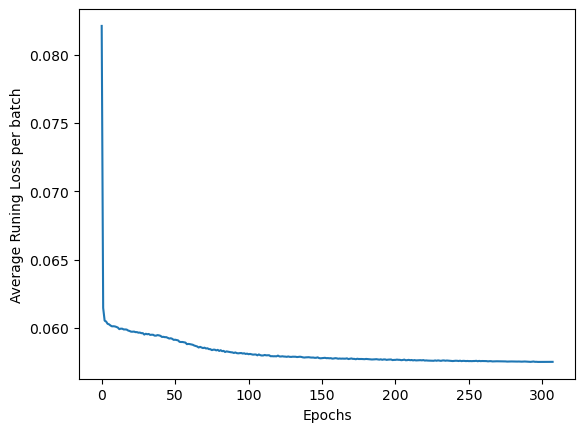

In [27]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [28]:
torch.save(final_model, 'model_100206_quarter_01.pt')

## TEST

In [32]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals') * 1e-3

In [34]:
normalized_scan_100307 = np.load("normalized_scan_100307_full.npy")

In [35]:
quarter_normalized_scan_100307 = normalized_scan_100307[:,0:80]

In [36]:
quarter_bvals_100307 = bvals_all_100307[0:80]

In [37]:
quarter_big_b_indices_100307 = np.where(quarter_bvals_100307 != 0.005)[0]

In [38]:
quarter_normalized_scan_100307_no_b5 = quarter_normalized_scan_100307[:, quarter_big_b_indices_100307]
quarter_bvals_100307_no_5 = quarter_bvals_100307[quarter_big_b_indices_100307]

In [39]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
quarter_n_100307 = n_all_100307[:, 0:80]
quarter_n_100307_no_5 = quarter_n_100307[:,quarter_big_b_indices_100307].T
print(quarter_n_100307_no_5.shape)

quarter_b_values_100307 = torch.FloatTensor(quarter_bvals_100307_no_5)
quarter_gradient_directions_100307 = torch.FloatTensor(quarter_n_100307_no_5)

(75, 3)


In [41]:
net_100307_quarter = BallStickNet(quarter_gradient_directions_100307, quarter_b_values_100307)
net_100307_quarter.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_quarter_01.pt"))
net_100307_quarter.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=75, out_features=75, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=75, out_features=75, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=75, out_features=75, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=75, out_features=75, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=75, out_features=75, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=75, out_features=75, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=75, out_features=5, bias=True)
  )
)

In [43]:
X_100307_quarter_pred, theta_100307_quarter_pred, phi_100307_quarter_pred, mu_cart_100307_quarter_pred, lambda_par_100307_quarter_pred, lambda_iso_100307_quarter_pred,  volume_0_100307_quarter_pred, volume_1_100307_quarter_pred = net_100307_quarter(torch.from_numpy(quarter_normalized_scan_100307_no_b5.astype(np.float32)))

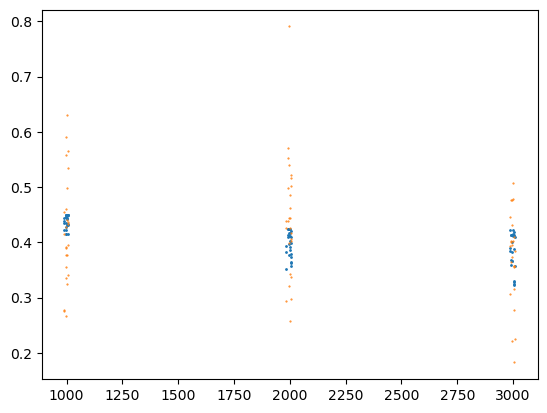

In [44]:
plt.plot(quarter_bvals_100307_no_5*1e03, X_100307_quarter_pred[1234,:].detach().numpy(),  "o", markersize = 1)
plt.plot(quarter_bvals_100307_no_5*1e03,quarter_normalized_scan_100307_no_b5[1234,:], ".", markersize = 1)

In [46]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

def back_to_3D(mask_long, parames_1d, shape):
    params_with_bg = add_bg(mask_long, parames_1d.detach().numpy())
    params_3d = np.reshape(params_with_bg, shape)
    return params_3d

In [47]:
lambda_par_100307_pred_3d = back_to_3D(mask_100307_long_pro, lambda_par_100307_quarter_pred, (145, 174, 145))
lambda_iso_100307_pred_3d = back_to_3D(mask_100307_long_pro, lambda_iso_100307_quarter_pred, (145, 174, 145))
volume_0_100307_pred_3d = back_to_3D(mask_100307_long_pro, volume_0_100307_quarter_pred, (145, 174, 145))
volume_1_100307_pred_3d = back_to_3D(mask_100307_long_pro, volume_1_100307_quarter_pred, (145, 174, 145))

In [48]:
import matplotlib

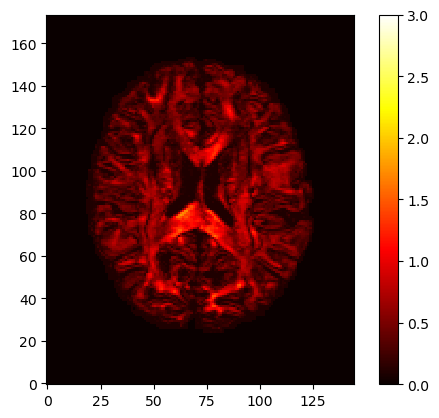

In [50]:
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

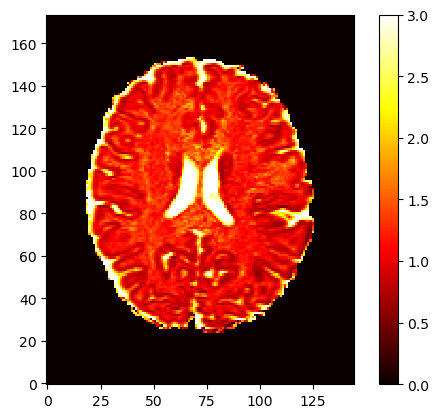

In [51]:
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

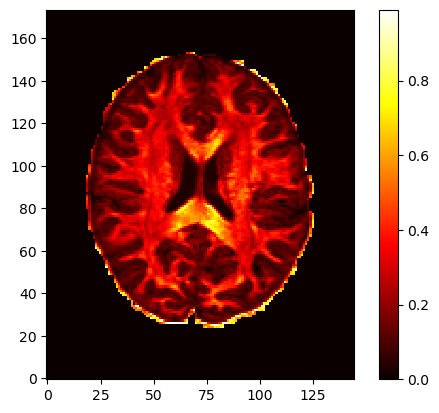

In [52]:
im = plt.imshow(volume_0_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

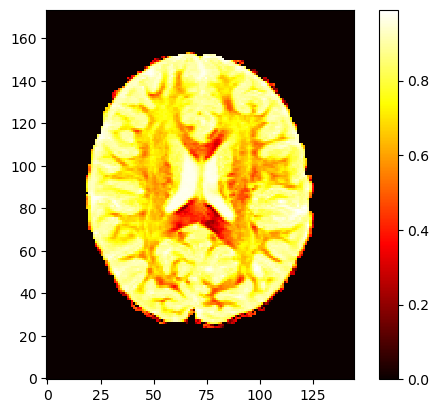

In [53]:
im = plt.imshow(volume_1_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)